In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
from torch.optim import AdamW, SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR, MultiStepLR, LambdaLR, CyclicLR
import torchvision
from torchvision import transforms, models
import torchvision.transforms as transforms
from torchvision import datasets
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from torchsummary import summary
from sklearn.metrics import classification_report
import albumentations as A
from IPython.display import Image
import albumentations as A
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from torch.utils.data.sampler import SubsetRandomSampler
import os
from shutil import copyfile
import random
import shutil

In [2]:
!mkdir  ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d yashvrdnjain/hotdognothotdog

 93% 155M/166M [00:01<00:00, 158MB/s]
100% 166M/166M [00:01<00:00, 130MB/s]


In [6]:
!unzip hotdognothotdog.zip

Archive:  hotdognothotdog.zip
  inflating: hotdog-nothotdog/test/hotdog/1501.jpg  
  inflating: hotdog-nothotdog/test/hotdog/1502.jpg  
  inflating: hotdog-nothotdog/test/hotdog/1503.jpg  
  inflating: hotdog-nothotdog/test/hotdog/1504.jpg  
  inflating: hotdog-nothotdog/test/hotdog/1505.jpg  
  inflating: hotdog-nothotdog/test/hotdog/1506.jpg  
  inflating: hotdog-nothotdog/test/hotdog/1507.jpg  
  inflating: hotdog-nothotdog/test/hotdog/1508.jpg  
  inflating: hotdog-nothotdog/test/hotdog/1509.jpg  
  inflating: hotdog-nothotdog/test/hotdog/1510.jpg  
  inflating: hotdog-nothotdog/test/hotdog/1511.jpg  
  inflating: hotdog-nothotdog/test/hotdog/1512.jpg  
  inflating: hotdog-nothotdog/test/hotdog/1513.jpg  
  inflating: hotdog-nothotdog/test/hotdog/1514.jpg  
  inflating: hotdog-nothotdog/test/hotdog/1515.jpg  
  inflating: hotdog-nothotdog/test/hotdog/1516.jpg  
  inflating: hotdog-nothotdog/test/hotdog/1517.jpg  
  inflating: hotdog-nothotdog/test/hotdog/1518.jpg  
  inflating: hot

Загружаем и обрабатываем данные:

In [7]:
from copy import copy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_data_path = "/content/hotdog-nothotdog/train"
test_data_path = "/content/hotdog-nothotdog/test"
bs = 64

preprocess_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
])

preprocess_val_test = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
])

full_train_dataset = datasets.ImageFolder(root=train_data_path)
train_dataset, val_dataset = random_split(full_train_dataset, [0.7, 0.3])
train_dataset.dataset = copy(full_train_dataset)
val_dataset.dataset.transform = preprocess_val_test
train_dataset.dataset.transform = preprocess_train

test_dataset = datasets.ImageFolder(root=test_data_path, transform=preprocess_val_test)
test_indices = list(range(len(test_dataset)))
random.shuffle(test_indices)

train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=bs)
test_loader = DataLoader(test_dataset, batch_size=bs, sampler = test_indices)


In [8]:
class_names = val_dataset.dataset.classes

label_to_class = val_dataset.dataset.class_to_idx
print(label_to_class)
class_count = {class_name: 0 for class_name in class_names}

for images, labels in val_loader:
    for label in labels:
        class_name = class_names[label.item()]
        class_count[class_name] += 1

for class_name, count in class_count.items():
    print(f'Validation: Class: {class_name}, Count: {count}')

{'hotdog': 0, 'nothotdog': 1}
Validation: Class: hotdog, Count: 452
Validation: Class: nothotdog, Count: 448


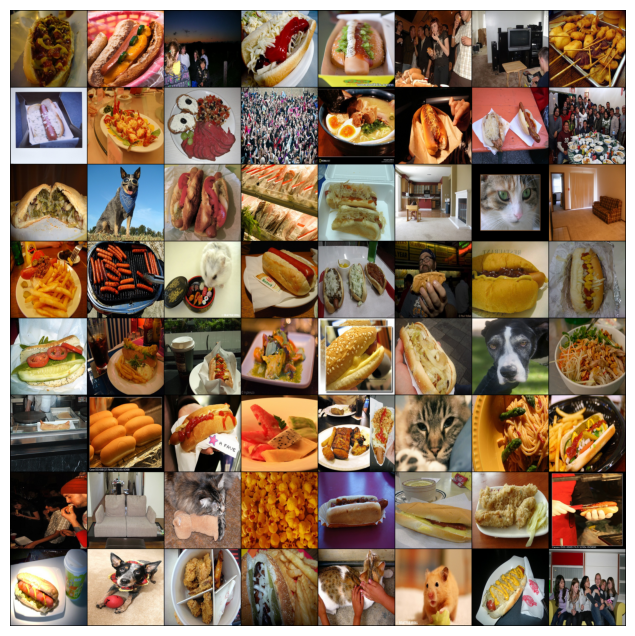

tensor([0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
        0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1])


In [9]:
def imshow(img_tensor):
    img = np.transpose(img_tensor.numpy(), (1, 2, 0))
    plt.imshow(img)
    plt.axis('off')

for images, labels in test_loader:
    plt.figure(figsize=(16, 8))
    imshow(torchvision.utils.make_grid(images))
    plt.show()
    print(labels)
    break

Создание класса модели:

In [10]:
class CustomMobileNetV2(nn.Module):
    def __init__(self, countOfClasses):
        super(CustomMobileNetV2, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.3)
        self.dense1 = nn.Linear(1280, 128)
        self.dense2 = nn.Linear(128, countOfClasses)

    def forward(self, x):
        x = self.mobilenet.features(x)
        x = self.global_avg_pooling(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.dense1(x)
        outputs = self.dense2(x)
        return outputs

Создание объекта класса модели

Выведем подробное описание нашей модели

In [11]:
model = CustomMobileNetV2(countOfClasses=2)
model = model.to(device)
# model.load_state_dict(torch.load('weights.pth'))

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=0.0001)

num_epochs = 20
# lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
# lr_scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 98.2MB/s]


Запустим тренировочный и валидационный циклы:

In [12]:
loss_train = []
loss_val = []
len_loader = len(train_loader)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    print("Epoch", epoch+1, ":")
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    # lr_scheduler.step()


    model.eval()
    with torch.no_grad():
        accuracy_list = []
        precision_list = []
        recall_list = []
        f1_list = []
        val_loss = 0.0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            _, predicted = torch.max(outputs, 1)

            loss_v = criterion(outputs, labels)
            # print(loss_v.item())
            val_loss += loss_v.item()

            labels_array = labels.cpu().numpy()
            predicted_array = predicted.cpu().numpy()

            precision = precision_score(labels_array, predicted_array, average='weighted', zero_division=0)
            recall = recall_score(labels_array, predicted_array, average='weighted', zero_division=0)
            f1 = f1_score(labels_array, predicted_array, average='weighted', zero_division=0)

            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)

        avg_precision = sum(precision_list) / len(precision_list)
        avg_recall = sum(recall_list) / len(recall_list)
        avg_f1 = sum(f1_list) / len(f1_list)

        train_loss = epoch_loss / len(train_loader)
        val_loss = val_loss/len(val_loader)
        print(f'      Training loss: {train_loss}\n      Validation loss: {val_loss}\n      Average Precision: {avg_precision}, Average Recall: {avg_recall}, Average F1-score: {avg_f1}')
        loss_val.append(val_loss)
        loss_train.append(train_loss)

Epoch 1 :
      Training loss: 0.7014145652453104
      Validation loss: 0.6580762028694153
      Average Precision: 0.6759901196375087, Average Recall: 0.6666666666666666, Average F1-score: 0.6646751188731496
Epoch 2 :
      Training loss: 0.6441967126094934
      Validation loss: 0.6071733673413594
      Average Precision: 0.7972289520913258, Average Recall: 0.7927083333333333, Average F1-score: 0.7921918626177082
Epoch 3 :
      Training loss: 0.5911391160704873
      Validation loss: 0.5616816600163778
      Average Precision: 0.8443926334110391, Average Recall: 0.8395833333333333, Average F1-score: 0.8391846487106152
Epoch 4 :
      Training loss: 0.5500185751553738
      Validation loss: 0.5220491349697113
      Average Precision: 0.8564882080022892, Average Recall: 0.8520833333333333, Average F1-score: 0.8517657772071867
Epoch 5 :
      Training loss: 0.5102850912195264
      Validation loss: 0.4848845442136129
      Average Precision: 0.8692388916254944, Average Recall: 0.86354

In [13]:
# torch.save(model.state_dict(), 'weights.pth')

Проверим модель на тестовой выборке

In [18]:
model.eval()
test_loss = []

with torch.no_grad():
        accuracy_list = []
        precision_list = []
        recall_list = []
        f1_list = []


        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            _, predicted = torch.max(outputs, 1)

            loss = criterion(outputs, labels)
            test_loss.append(loss)

            labels_array = labels.cpu().numpy()
            predicted_array = predicted.cpu().numpy()

            # Расчет метрик
            precision = precision_score(labels_array, predicted_array, average='weighted', zero_division=0)
            recall = recall_score(labels_array, predicted_array, average='weighted', zero_division=0)
            f1 = f1_score(labels_array, predicted_array, average='weighted', zero_division=0)
            accuracy = accuracy_score(labels_array, predicted_array)

            accuracy_list.append(accuracy)
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)

        avg_precision = sum(precision_list) / len(precision_list)
        avg_recall = sum(recall_list) / len(recall_list)
        avg_f1 = sum(f1_list) / len(f1_list)

print(f'\nAverage Precision: {avg_precision}, Average Recall: {avg_recall}, Average F1-score: {avg_f1}')



Average Precision: 0.9155080868671587, Average Recall: 0.9034090909090909, Average F1-score: 0.9019353299102413


Выведем графики:

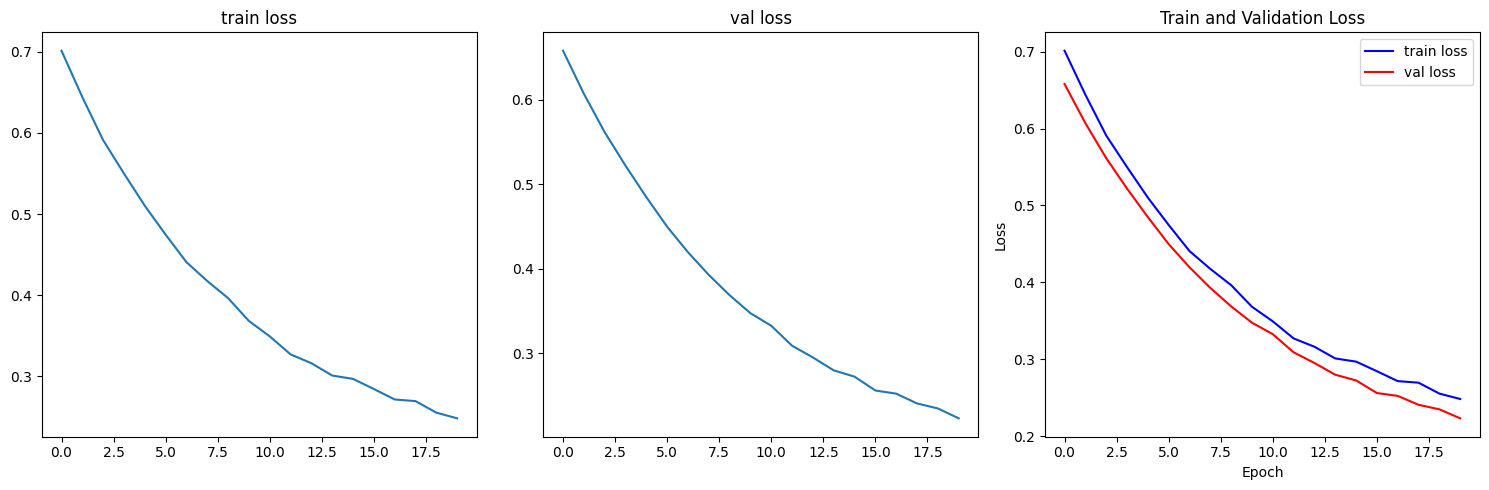

In [19]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('train loss')
plt.plot(loss_train)

plt.subplot(1, 3, 2)
plt.title('val loss')
plt.plot(loss_val)

plt.subplot(1, 3, 3)
plt.plot(loss_train, label='train loss', color='blue')
plt.plot(loss_val, label='val loss', color='red')

plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

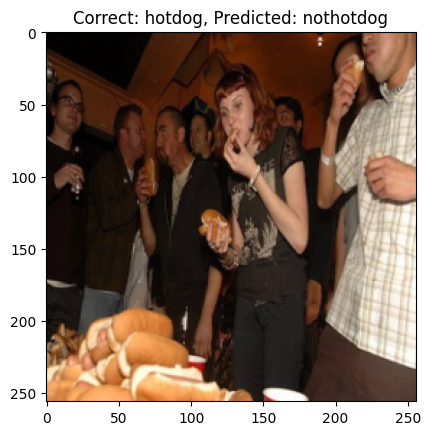

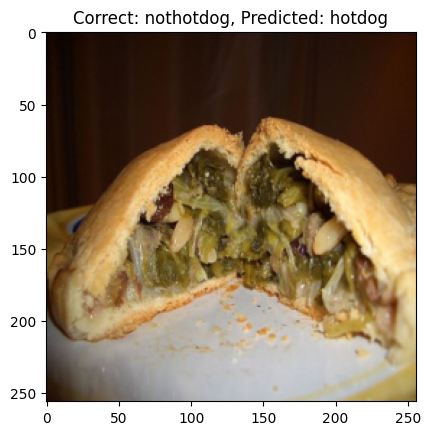

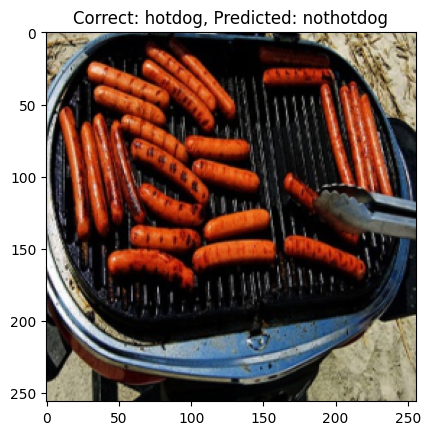

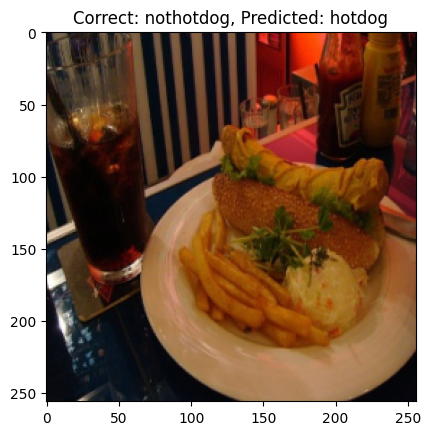

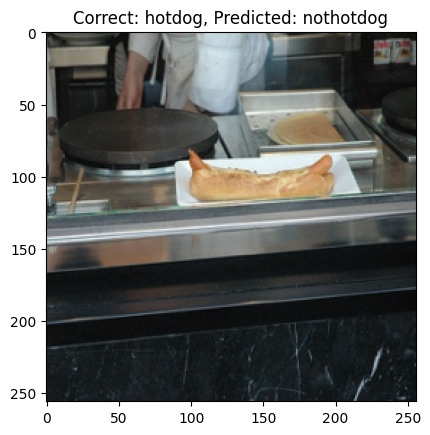

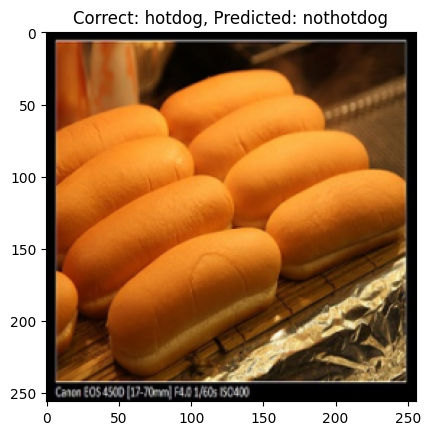

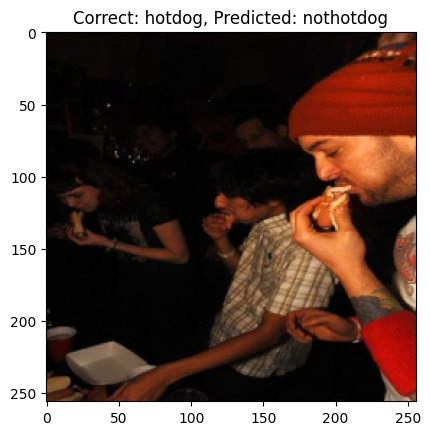

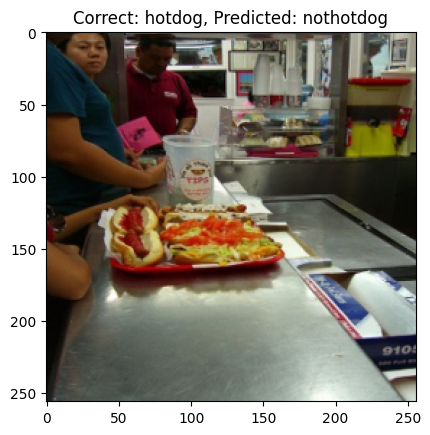

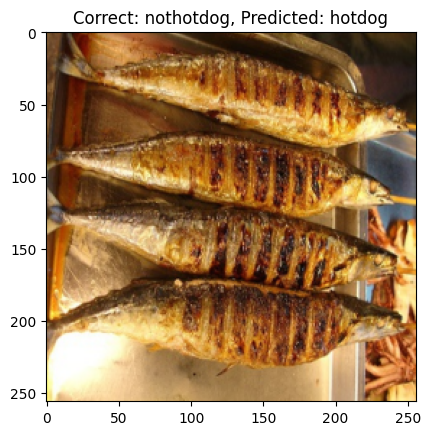

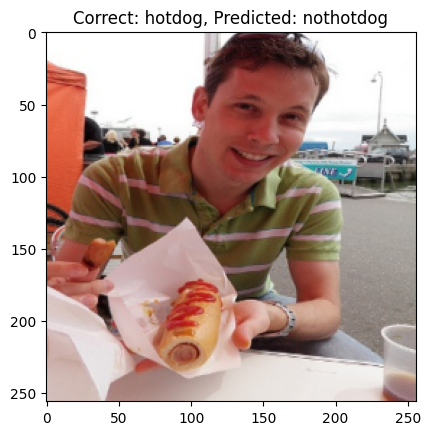

In [22]:
#где модель ошиблась


model.eval()

incorrect_images = []
correct_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs, 1)

        incorrect_mask = predicted != labels
        incorrect_images.extend(images[incorrect_mask])
        correct_labels.extend(labels[incorrect_mask])
        predicted_labels.extend(predicted[incorrect_mask])

# Вывод изображений, на которых модель ошиблась
num_images_to_show = 10
for i in range(min(num_images_to_show, len(incorrect_images))):
    image = incorrect_images[i].cpu()
    correct_label = correct_labels[i].cpu().item()
    predicted_label = predicted_labels[i].cpu().item()

    plt.imshow(torchvision.utils.make_grid(image, nrow=1).permute(1, 2, 0))
    plt.title(f'Correct: {class_names[correct_label]}, Predicted: {class_names[predicted_label]}')
    plt.show()

In [34]:
#просто предсказания
preprocess_predict = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
])

def predict_and_display_image(image_path, model, label_to_class):
    image = Image.open(image_path)
    image = preprocess_predict(image)
    image = image.unsqueeze(0)

    model.eval()
    with torch.no_grad():
        image = image.to(device)
        output = model(image)
        _, predicted = torch.max(output, 1)
        prediction = predicted.item()

    predicted_class_name = list(label_to_class.keys())[list(label_to_class.values()).index(prediction)]

    image = image.cpu()

    plt.imshow(image.squeeze(0).permute(1, 2, 0))
    plt.axis('off')
    plt.title(f'Predicted Class: {predicted_class_name}')
    plt.show()

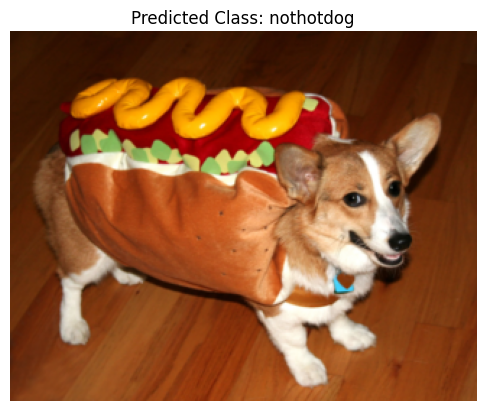

In [23]:
predict_and_display_image('/content/dog_hot_dog.jpg', model, label_to_class)

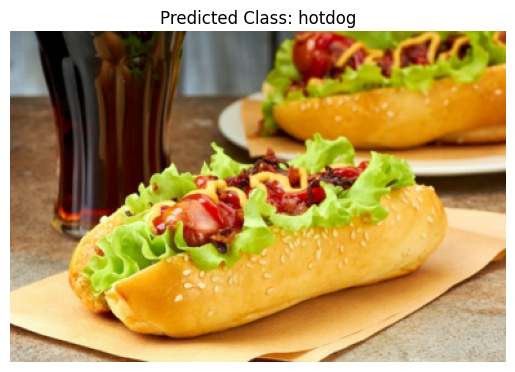

In [24]:
predict_and_display_image('/content/hotdog.jpg', model, label_to_class)

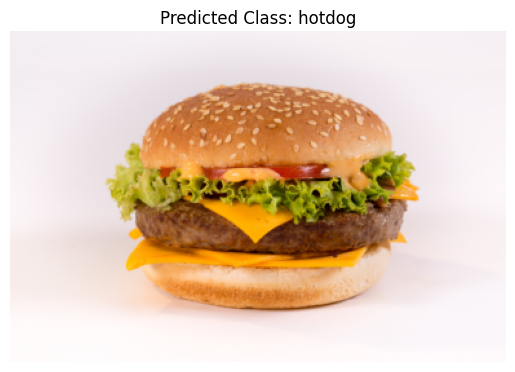

In [25]:
predict_and_display_image('/content/burger.jpg', model, label_to_class)

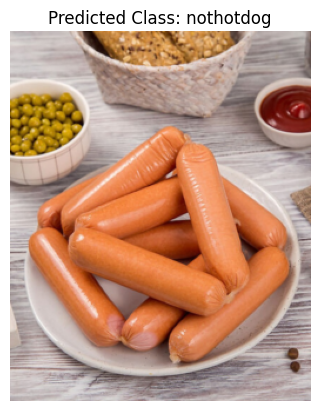

In [26]:
predict_and_display_image('/content/sos.jpg', model, label_to_class)

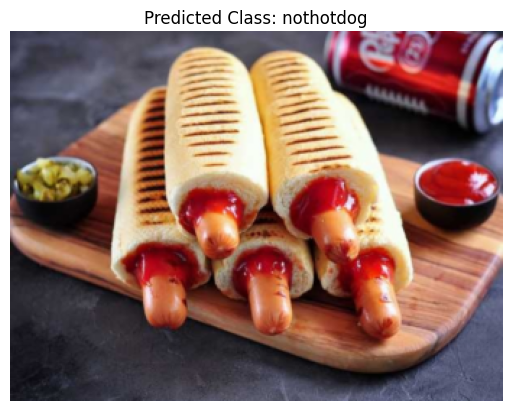

In [27]:
predict_and_display_image('/content/hotdogs.jpg', model, label_to_class)

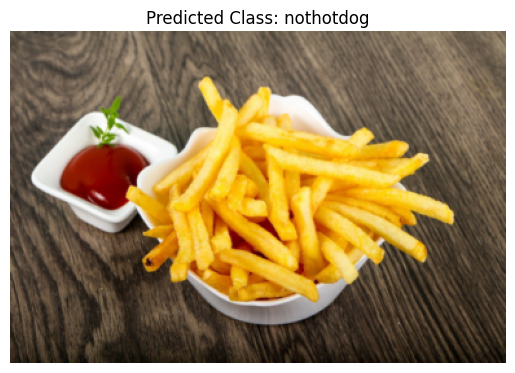

In [28]:
predict_and_display_image('/content/fries.jpg', model, label_to_class)

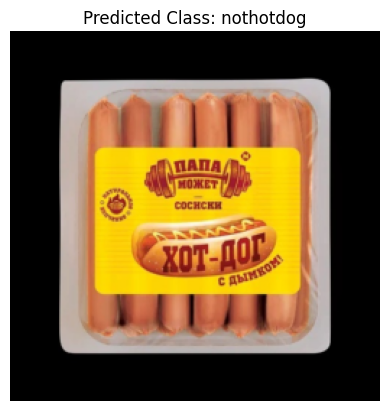

In [29]:
predict_and_display_image('/content/sas.jpg', model, label_to_class)

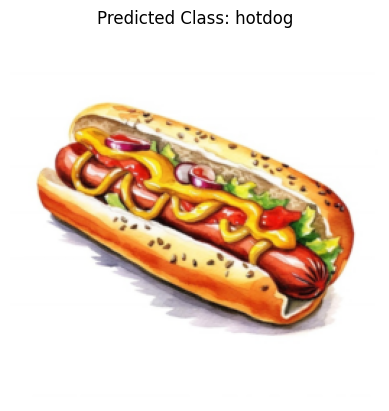

In [30]:
predict_and_display_image('/content/hot.jpg', model, label_to_class)

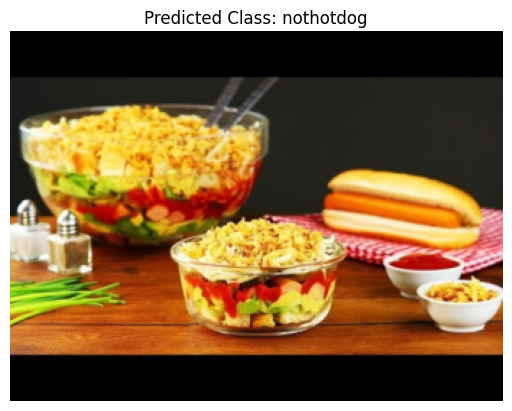

In [31]:
predict_and_display_image('/content/salad.jpg', model, label_to_class)

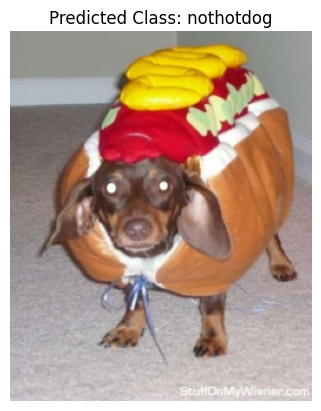

In [32]:
predict_and_display_image('/content/dog.jpg', model, label_to_class)

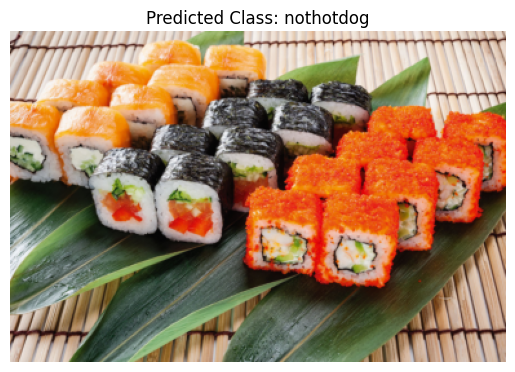

In [33]:
predict_and_display_image('/content/sushi.png', model, label_to_class)